In [1]:
import sys,os,argparse,time
import numpy as np
import torch
import utils
from datetime import datetime
import pickle
import pandas as pd
tstart=time.time()
import matplotlib.pyplot as plt 
from tabulate import tabulate
from prettytable import PrettyTable

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Arguments
parser=argparse.ArgumentParser(description='xxx')
parser.add_argument('--seed',               default=0,                    type=int,     help='(default=%(default)d)')
parser.add_argument('--device',             default='cpu',                type=str,     help='gpu id')
parser.add_argument('--experiment',         default='2_task_groups',     type =str,    help='Mnist or dissertation')
parser.add_argument('--approach',           default='PUGCL',              type =str,    help='Method, always Lifelong Uncertainty-aware learning')
parser.add_argument('--data_path',          default='data/data_test.csv', type=str,     help='gpu id')

# Training parameters
parser.add_argument('--output',             default='',                           type=str,     help='')
parser.add_argument('--checkpoint_dir',     default='../checkpoints_2_tasks',    type=str,     help='')
parser.add_argument('--n_epochs',           default=100,                          type=int,     help='')
parser.add_argument('--batch_size',         default=64,                           type=int,     help='')
parser.add_argument('--lr',                 default=0.03,                         type=float,   help='')
parser.add_argument('--hidden_size',        default=800,                          type=int,     help='')
parser.add_argument('--parameter',          default='',                           type=str,     help='')

# UCB HYPER-PARAMETERS
parser.add_argument('--MC_samples',         default='10',           type=int,     help='Number of Monte Carlo samples')
parser.add_argument('--rho',                default='-3',           type=float,   help='Initial rho')
parser.add_argument('--sigma1',             default='0.0',          type=float,   help='STD foor the 1st prior pdf in scaled mixture Gaussian')
parser.add_argument('--sigma2',             default='6.0',          type=float,   help='STD foor the 2nd prior pdf in scaled mixture Gaussian')
parser.add_argument('--pi',                 default='0.25',         type=float,   help='weighting factor for prior')

parser.add_argument('--resume',             default='no',           type=str,     help='resume?')
parser.add_argument('--sti',                default=1,              type=int,     help='starting task?')

parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

args=parser.parse_args()
utils.print_arguments(args)

Arguments =
	seed: 0
	device: cpu
	experiment: 2_task_groups
	approach: PUGCL
	data_path: data/data_test.csv
	output: 
	checkpoint_dir: ../checkpoints_2_tasks
	n_epochs: 100
	batch_size: 64
	lr: 0.03
	hidden_size: 800
	parameter: 
	MC_samples: 10
	rho: -3.0
	sigma1: 0.0
	sigma2: 6.0
	pi: 0.25
	resume: no
	sti: 1
	fff: /Users/jonastjomsland/Library/Jupyter/runtime/kernel-73478b48-39d9-48a7-9058-b5fbe6df912d.json


In [4]:
# Set seed for stable results
#np.random.seed(args.seed)
#torch.manual_seed(args.seed)

# Check if Cuda is available
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Using device:", args.device)

# PUGCL with two tasks:
from data import dataloader_2_tasks as dataloader

# Import Lifelong Uncertainty-aware Learning approach:
#from bayesian_model.lul import Lul
from training_method import PUGCL

# Import model used:
#from bayesian_model.bayesian_network import BayesianNetwork
from bayesian_model.bayesian_network2 import BayesianNetwork

# Load training data:
print("Loading data...")
data, task_outputs, input_size = dataloader.get(data_path='data/data.csv')
print("Input size =", input_size, "\nTask info =", task_outputs)
print("Number of data samples: ", len(data[0]['train']['x']))
args.num_tasks = len(task_outputs)
args.input_size = input_size
args.task_outputs = task_outputs

# Used to load best model:
args.approach = 'PUGCL_skewed_data'

# Hardcode hidden size from parameter search:
args.hidden_size = 800
task_order = [1, 0]

# Checkpoint for this run
checkpoint = utils.make_directories(args)
args.checkpoint = checkpoint
print(checkpoint)

# Initialize Bayesian network
print("Initializing network...")
model = BayesianNetwork(args).to(args.device)

# Initialize Lul approach
print("Initialize Lifelong Uncertainty-aware Learning")
approach = PUGCL(model, args=args)
print("-"*100)

# Load stored model:
# Need to read text file to see order of trained tasks!! In this case order was [1 0], hence model 0 is the latest
model_number = 1
checkpoint = torch.load(os.path.join(args.checkpoint, 'model_{}.pth.tar'.format(model_number)), map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device=args.device).eval()

Using device: cpu
Loading data...
Input size = [1, 29] 
Task info = [(0, 16), (1, 16)]
Number of data samples:  4400
Results will be saved in  ../checkpoints_2_tasks/2_task_groups_PUGCL_skewed_data
../checkpoints_2_tasks/2_task_groups_PUGCL_skewed_data
Initializing network...
Initialize Lifelong Uncertainty-aware Learning
----------------------------------------------------------------------------------------------------


In [5]:
# Load features:
df_x1 = pd.read_csv('/Users/jonastjomsland/Dissertation/scripts_and_data/features4.csv')
df_x1 = df_x1.iloc[:, :-1]
df_x2 = pd.read_csv('/Users/jonastjomsland/Dissertation/data/features5.csv', sep=';')
df_x2.columns = df_x2.iloc[0]
df_x2 = df_x2.drop(df_x2.index[0])
df_x2 = df_x2.iloc[:, :-1]

features = pd.concat([df_x1, df_x2])
features = features.iloc[:-40,:-12]
features['Stamp'] = features['Stamp'].astype(int)

In [6]:
# Load test data:
full_set = pd.read_csv(args.data_path)
full_set['Stamp'] = full_set['Stamp'].astype(int)
# Split in circle and arrow
df_circle = full_set[full_set['Using circle'] == 1]
df_arrow = full_set[full_set['Using circle'] == 0]
actions = [['Vacuum cleaning', 'Mopping the floor', 'Carry warm food', 'Carry cold food', 'Carry drinks', 'Carry small objects (plates, toys)', 'Carry big objects (tables, chairs)', 'Cleaning (Picking up stuff)'], ['Vacuum cleaning', 'Mopping the floor', 'Carry warm food', 'Carry cold food', 'Carry drinks', 'Carry small objects (plates, toys)', 'Carry big objects (tables, chairs)', 'Starting conversation']]
display(df_circle)


Stamp  Using circle  Using arrow  Number of people  \
0       870           1.0          0.0          0.000000   
1       870           1.0          0.0          0.000000   
2       870           1.0          0.0          0.000000   
3       870           1.0          0.0          0.000000   
4       870           1.0          0.0          0.000000   
...     ...           ...          ...               ...   
1389    706           1.0          0.0          0.444444   
1390    706           1.0          0.0          0.444444   
1391    706           1.0          0.0          0.444444   
1392    706           1.0          0.0          0.444444   
1393    706           1.0          0.0          0.444444   

      Number of people in group  Group radius  Distance to group  \
0                           0.0           1.0                1.0   
1                           0.0           1.0                1.0   
2                           0.0           1.0                1.0   
3                           0.0           1.0                1.0   
4                           0.0           1.0                1.0   
...                         ...           ...                ...   
1389                        0.0           1.0                1.0   
1390                        0.0           1.0                1.0   
1391                        0.0           1.0                1.0   
1392                        0.0           1.0                1.0   
1393                        0.0           1.0                1.0   

      Robot within group?  Robot facing group?  Robot work radius  ...  \
0                     0.0                  0.0           0.285126  ...   
1                     0.0                  0.0           0.285126  ...   
2                     0.0                  0.0           0.285126  ...   
3                     0.0                  0.0           0.285126  ...   
4                     0.0                  0.0           0.285126  ...   
...                   ...                  ...                ...  ...   
1389                  0.0                  0.0           0.299117  ...   
1390                  0.0                  0.0           0.299117  ...   
1391                  0.0                  0.0           0.299117  ...   
1392                  0.0                  0.0           0.299117  ...   
1393                  0.0                  0.0           0.299117  ...   

      Music playing?  Number of agents in scene  Vacuum cleaning  \
0                0.0                        0.0              5.0   
1                0.0                        0.0              5.0   
2                0.0                        0.0              5.0   
3                0.0                        0.0              5.0   
4                0.0                        0.0              5.0   
...              ...                        ...              ...   
1389             0.0                        0.4              4.0   
1390             0.0                        0.4              2.0   
1391             0.0                        0.4              2.0   
1392             0.0                        0.4              3.0   
1393             0.0                        0.4              1.0   

      Mopping the floor  Carry warm food  Carry cold food  Carry drinks  \
0                   5.0              5.0              5.0           5.0   
1                   5.0              2.0              2.0           2.0   
2                   5.0              5.0              5.0           5.0   
3                   5.0              5.0              5.0           5.0   
4                   5.0              5.0              5.0           5.0   
...                 ...              ...              ...           ...   
1389                4.0              3.0              3.0           3.0   
1390                2.0              2.0              2.0           4.0   
1391                2.0              4.0              4.0           4.0   
1392        

In [7]:
# Do 100 MC samples of inference 
x_circle = torch.tensor(df_circle.iloc[:,0:30].drop_duplicates().values).type(torch.float32)
x_arrow = torch.tensor(df_arrow.iloc[:,0:30].drop_duplicates().values).type(torch.float32)
test_scenes = [[df_circle.iloc[:,0:30].drop_duplicates().Stamp.values][0], [df_arrow.iloc[:,0:30].drop_duplicates().Stamp.values][0]]
# Dict for model output
model_output = {}
first_it = True
for sample in range(100):
    output_circle = model(x_circle[:,1:], sample = False, sample_last_layer = True)
    output_arrow = model(x_arrow[:,1:], sample = False, sample_last_layer = True)
    # Append output
    # Circle actions
    if first_it:
        model_output[0] = output_circle[0].detach().numpy()
    else:
        model_output[0] = np.dstack([model_output[0],output_circle[0].detach().numpy()])
    # Arrow actions
    if first_it:
        model_output[1] = output_arrow[1].detach().numpy()
    else:
        model_output[1] = np.dstack([model_output[1],output_arrow[1].detach().numpy()])
    first_it = False
print(model_output[0].shape)
print(model_output[1].shape)

(41, 16, 100)
(59, 16, 100)


In [8]:
evaluation_dict = {}
for action_index, action_type in enumerate(test_scenes):
    for scene_index, scene in enumerate(action_type):
        evaluation_dict[scene] = {}
        # Scene stamp for image
        evaluation_dict[scene]['Stamp'] = scene
        
        # Features of the scene
        evaluation_dict[scene]['Features'] = features[features.Stamp == scene].values[0][2:].astype(float)
        # Actions for that scene
        evaluation_dict[scene]['Actions'] = actions[int(evaluation_dict[scene]['Features'][1])]
        
        # Using circle or arrow
        if evaluation_dict[scene]['Features'][0] == 1:
            # Scene is with circle
            evaluation_dict[scene]['Using circle'] = True
            scene_df = df_circle[df_circle.Stamp == scene]
        else:
            evaluation_dict[scene]['Using circle'] = False
            scene_df = df_arrow[df_arrow.Stamp == scene]
        
        # Labeled answers
        evaluation_dict[scene]['Mean label'] = scene_df.mean(axis = 0).values[30:]
        evaluation_dict[scene]['Variance in labels'] = scene_df.var(axis = 0).values[30:]
        
        # Predicted values:
        evaluation_dict[scene]['Predicted mean'] = []
        evaluation_dict[scene]['Aleatoric uncertainty'] = []
        evaluation_dict[scene]['Epistemic uncertainty'] = []

        mean = model_output[action_index][scene_index, 0:8, :]
        variance = np.exp(model_output[action_index][scene_index , 8:, :])

        # Append predictive mean
        evaluation_dict[scene]['Predicted mean'] = np.mean(mean, axis = 1)
        # Append Aleatoric
        evaluation_dict[scene]['Aleatoric uncertainty'] = np.mean(variance, axis = 1)
        # Append Epistemic
        evaluation_dict[scene]['Epistemic uncertainty'] = np.mean(np.square(mean), axis = 1) - np.square(np.mean(mean, axis = 1))
            
        

In [9]:
scene_df = df_arrow[df_arrow.Stamp == 720]
print(scene_df.var(axis = 0).values[30:])
print(evaluation_dict[720]['Predicted mean'])
#display(scene_df)

[1.2967033  1.05494505 1.82417582 1.69230769 1.82417582 1.93956044
 2.37912088 1.91758242]
[4.226933  4.460288  3.5017917 3.5698278 3.356456  3.9511514 3.7561462
 2.52115  ]


In [10]:
# Look at difference in average epistemic uncertainty
epistemic = [[],[]]
for action_type_index, action_type in enumerate(test_scenes):
    for scene_index, scene in enumerate(action_type):
        epistemic[action_type_index].append(np.mean(evaluation_dict[scene]['Epistemic uncertainty']))
print("Task 0 average epistemic uncertainty: ", np.mean(epistemic[0]))
print("Task 1 average epistemic uncertainty: ", np.mean(epistemic[1]))

# When training on both: (task 0 first)
#Task 0 average epistemic uncertainty:  0.12306646
#Task 1 average epistemic uncertainty:  0.14731094
# When only trained on task 0:
# Task 0 average epistemic uncertainty:  0.12667115
# Task 1 average epistemic uncertainty:  0.1641701

Task 0 average epistemic uncertainty:  0.13027327
Task 1 average epistemic uncertainty:  0.15101238


Scene number: 833


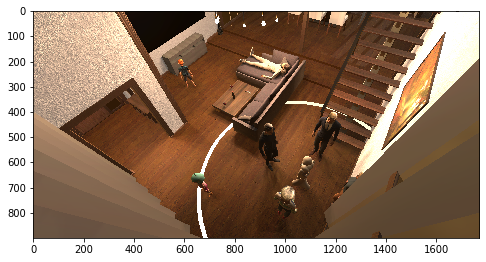

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.358        |         2.7555        |         0.1514        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.083333        1.822497
Mopping the floor                     2.250000       -0.235409
Carry warm food                       2.750000       -0.943842
Carry cold food                       3.083333        0.964633
Carry drinks                          3.083333       -0.095730
Carry small objects (plates, toys)    3.166667       -0.648819
Carry big objects (tables, chairs)    2.083333        0.087878
Cleaning (Picking up stuff)           2.833333       -0.547274

Scene number: 372


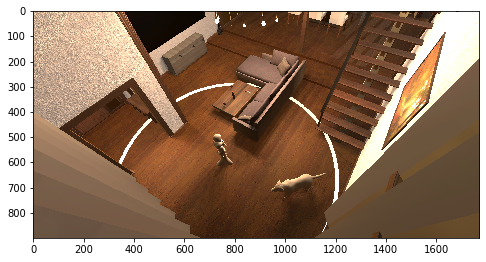

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.4183       |         2.4741        |         0.1836        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       3.071429        2.596350
Mopping the floor                     3.428571        0.557551
Carry warm food                       2.142857       -0.657891
Carry cold food                       2.285714        0.583621
Carry drinks                          2.214286       -0.720370
Carry small objects (plates, toys)    3.928571       -0.994151
Carry big objects (tables, chairs)    2.928571        0.400830
Cleaning (Picking up stuff)           3.785714       -0.881816

Scene number: 275


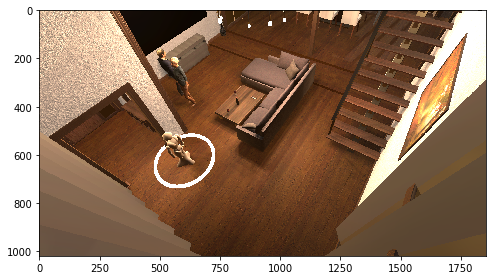

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.1133       |         1.9813        |         0.1182        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       4.000000        2.174045
Mopping the floor                     4.105263        0.792253
Carry warm food                       4.105263       -0.614077
Carry cold food                       4.105263        0.190802
Carry drinks                          4.052632        0.318919
Carry small objects (plates, toys)    4.157895       -0.786236
Carry big objects (tables, chairs)    4.052632       -0.015321
Cleaning (Picking up stuff)           4.157895       -0.255533

Scene number: 897


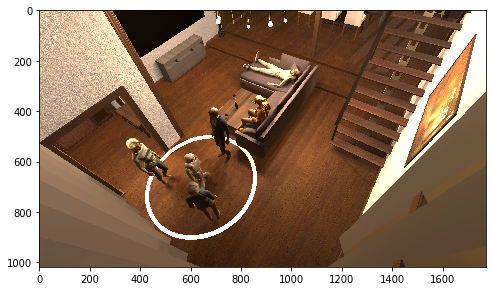

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       0.9886       |         2.3533        |         0.1405        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       1.583333        1.882324
Mopping the floor                     1.666667        0.159758
Carry warm food                       3.833333       -0.862654
Carry cold food                       3.833333        0.972794
Carry drinks                          3.750000        0.428031
Carry small objects (plates, toys)    3.750000       -0.756640
Carry big objects (tables, chairs)    1.333333       -0.703307
Cleaning (Picking up stuff)           3.416667       -0.458952

Scene number: 837


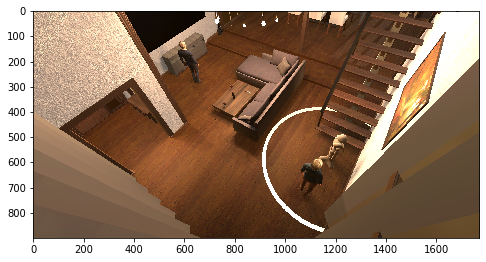

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.4265       |         2.4928        |         0.1456        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.785714        2.486639
Mopping the floor                     2.857143        0.791450
Carry warm food                       3.357143       -0.804909
Carry cold food                       3.357143        0.395764
Carry drinks                          3.357143       -0.179424
Carry small objects (plates, toys)    3.428571       -0.757167
Carry big objects (tables, chairs)    2.214286       -0.071353
Cleaning (Picking up stuff)           3.714286       -0.297676

Scene number: 747


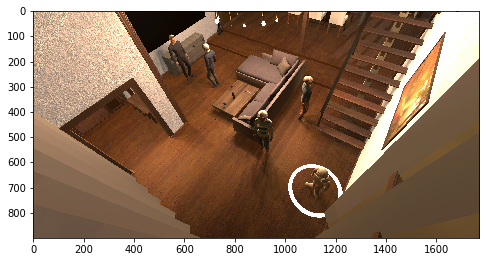

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.0737       |         1.5991        |         0.0994        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       3.384615        1.858032
Mopping the floor                     3.461538        0.726623
Carry warm food                       3.692308       -0.608363
Carry cold food                       3.692308        0.317406
Carry drinks                          3.846154        0.736557
Carry small objects (plates, toys)    3.538462       -0.339071
Carry big objects (tables, chairs)    2.615385       -0.322609
Cleaning (Picking up stuff)           3.461538       -0.607604

Scene number: 397


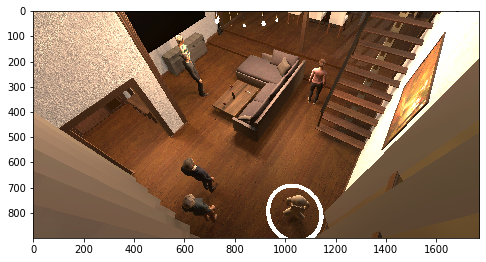

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       2.0593       |         1.7207        |         0.1111        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.461538        1.767068
Mopping the floor                     2.692308        0.945689
Carry warm food                       3.153846       -0.526614
Carry cold food                       3.153846        0.333433
Carry drinks                          3.153846        0.532735
Carry small objects (plates, toys)    3.384615       -0.291055
Carry big objects (tables, chairs)    2.692308       -0.816410
Cleaning (Picking up stuff)           3.692308       -0.921820

Scene number: 339


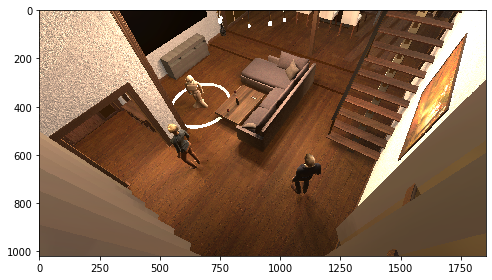

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.5735       |         2.3348        |         0.1382        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       3.214286        2.163546
Mopping the floor                     3.642857        0.904903
Carry warm food                       3.142857       -0.861058
Carry cold food                       3.142857        0.241645
Carry drinks                          3.142857        0.147728
Carry small objects (plates, toys)    3.785714       -0.758708
Carry big objects (tables, chairs)    2.857143       -0.413918
Cleaning (Picking up stuff)           3.714286       -0.745292

Scene number: 329


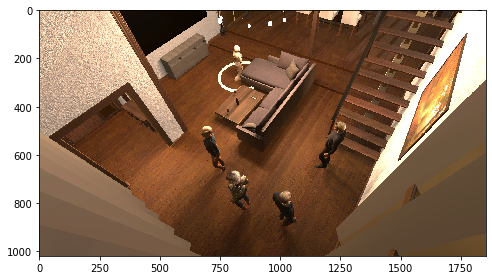

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.1954       |         1.8688        |         0.1164        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.806452        2.314832
Mopping the floor                     3.000000        0.631512
Carry warm food                       2.935484       -0.892623
Carry cold food                       3.000000        0.555340
Carry drinks                          3.032258        0.611380
Carry small objects (plates, toys)    3.225806       -0.501110
Carry big objects (tables, chairs)    2.290323       -0.503758
Cleaning (Picking up stuff)           3.774194       -0.542757

Scene number: 786


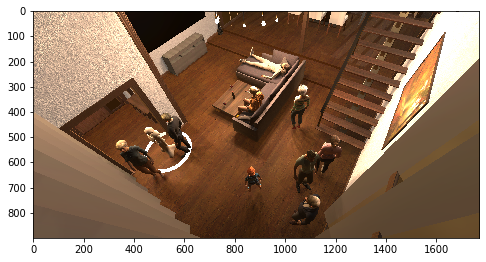

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.1923       |         2.1345        |         0.1417        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.285714        1.463097
Mopping the floor                     2.142857        0.366265
Carry warm food                       3.000000       -0.957740
Carry cold food                       3.357143        0.262016
Carry drinks                          3.357143        0.376269
Carry small objects (plates, toys)    3.285714       -0.640781
Carry big objects (tables, chairs)    2.071429        0.046194
Cleaning (Picking up stuff)           2.642857       -0.907625

Scene number: 919


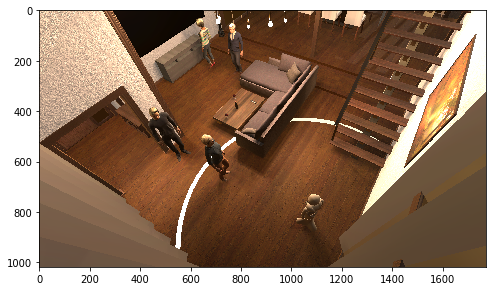

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.176        |         2.148         |         0.1628        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                         3.1250        3.307747
Mopping the floor                       3.0625        0.126268
Carry warm food                         3.8125       -1.597408
Carry cold food                         3.9375        0.309263
Carry drinks                            3.8750        0.285440
Carry small objects (plates, toys)      4.0625       -0.939177
Carry big objects (tables, chairs)      3.3125       -0.106593
Cleaning (Picking up stuff)             4.0625       -0.599753

Scene number: 530


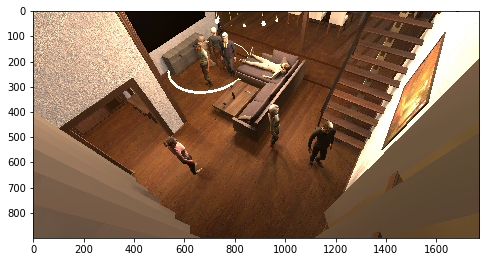

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.7536       |         1.6575        |         0.1398        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.066667        1.816529
Mopping the floor                     2.000000        0.745926
Carry warm food                       2.666667       -0.723930
Carry cold food                       2.933333       -0.056244
Carry drinks                          2.933333        0.383855
Carry small objects (plates, toys)    2.733333       -0.708538
Carry big objects (tables, chairs)    2.066667       -0.662126
Cleaning (Picking up stuff)           2.200000       -0.990440

Scene number: 318


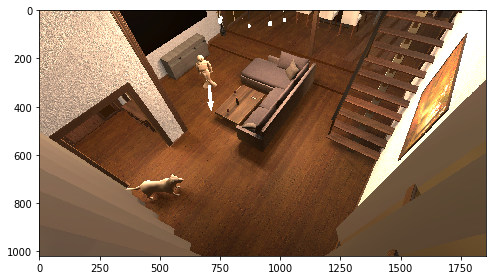

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.6143       |         1.543         |         0.1991        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       4.000000        3.832203
Mopping the floor                     3.533333        3.802569
Carry warm food                       2.466667        2.976263
Carry cold food                       2.533333        2.964796
Carry drinks                          2.666667        2.990464
Carry small objects (plates, toys)    3.200000        3.817184
Carry big objects (tables, chairs)    2.733333        3.371599
Starting conversation                 2.066667        2.311806

Scene number: 594


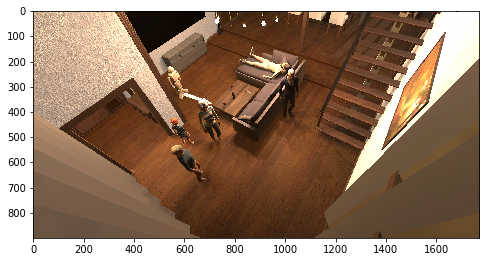

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.9036       |         1.3884        |         0.1529        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.133333        2.633498
Mopping the floor                     2.200000        2.611552
Carry warm food                       3.133333        3.395026
Carry cold food                       3.533333        3.520655
Carry drinks                          3.533333        3.726686
Carry small objects (plates, toys)    3.800000        3.342733
Carry big objects (tables, chairs)    1.866667        2.253338
Starting conversation                 2.866667        3.478303

Scene number: 271


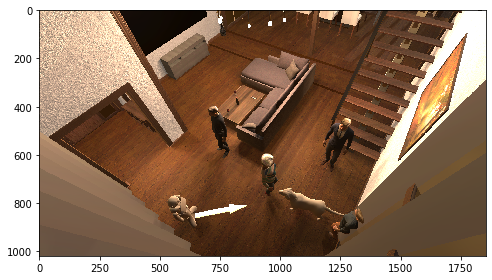

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.8821       |         1.3847        |         0.1197        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.666667        1.691645
Mopping the floor                     2.571429        1.563627
Carry warm food                       2.523810        3.099259
Carry cold food                       2.857143        3.181267
Carry drinks                          2.952381        2.779511
Carry small objects (plates, toys)    3.380952        3.034534
Carry big objects (tables, chairs)    2.333333        1.794546
Starting conversation                 4.380952        3.339734

Scene number: 991


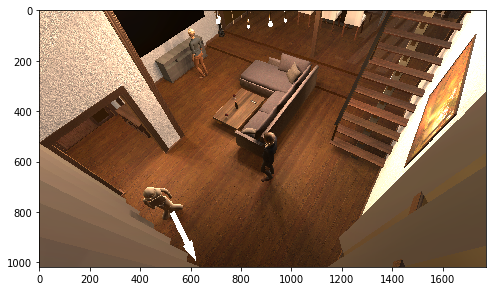

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.7212       |         1.4777        |         0.175         |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       4.142857        3.199666
Mopping the floor                     3.642857        3.359084
Carry warm food                       3.714286        3.267880
Carry cold food                       3.714286        3.383240
Carry drinks                          3.714286        3.433561
Carry small objects (plates, toys)    4.000000        3.678529
Carry big objects (tables, chairs)    3.500000        2.978691
Starting conversation                 3.000000        3.262657

Scene number: 731


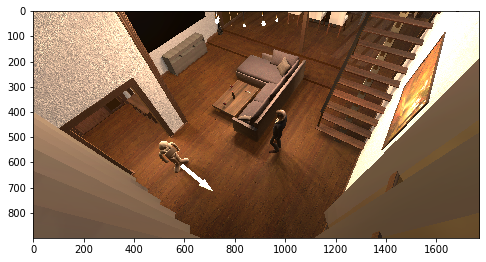

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.1226       |         1.4035        |         0.1945        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       4.133333        3.742283
Mopping the floor                     4.333333        3.790439
Carry warm food                       3.666667        3.486939
Carry cold food                       3.666667        3.387842
Carry drinks                          3.800000        3.688252
Carry small objects (plates, toys)    4.266667        3.715523
Carry big objects (tables, chairs)    4.066667        3.197230
Starting conversation                 3.133333        2.997184

Scene number: 324


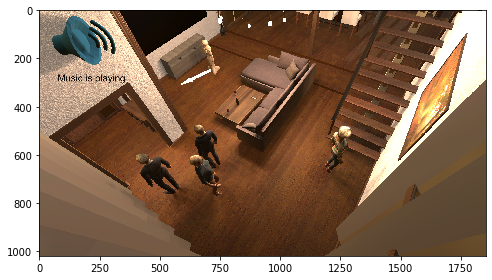

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.5242       |         1.2641        |         0.1318        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.608696        2.822891
Mopping the floor                     3.086957        2.994319
Carry warm food                       3.695652        3.380163
Carry cold food                       3.782609        3.393963
Carry drinks                          3.782609        3.286648
Carry small objects (plates, toys)    3.913043        3.757588
Carry big objects (tables, chairs)    3.086957        2.771163
Starting conversation                 2.869565        3.001521

Scene number: 518


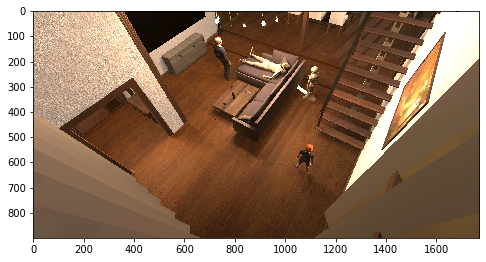

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.0821       |         1.4677        |         0.1507        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.200000        2.487856
Mopping the floor                     2.066667        2.273772
Carry warm food                       2.666667        3.267447
Carry cold food                       3.066667        3.555692
Carry drinks                          2.933333        3.513596
Carry small objects (plates, toys)    3.133333        3.159527
Carry big objects (tables, chairs)    2.333333        2.153093
Starting conversation                 3.600000        3.606238

Scene number: 304


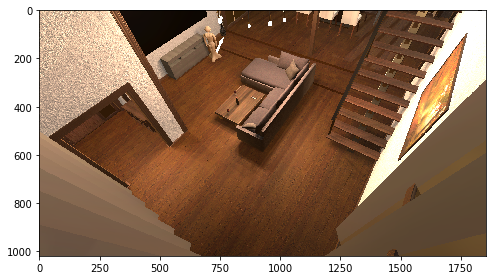

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.2018       |         1.5647        |         0.2099        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       4.722222        4.226933
Mopping the floor                     4.611111        4.460288
Carry warm food                       3.666667        3.501792
Carry cold food                       3.666667        3.569828
Carry drinks                          3.666667        3.356456
Carry small objects (plates, toys)    4.222222        3.951151
Carry big objects (tables, chairs)    4.000000        3.756146
Starting conversation                 2.555556        2.521150

Scene number: 309


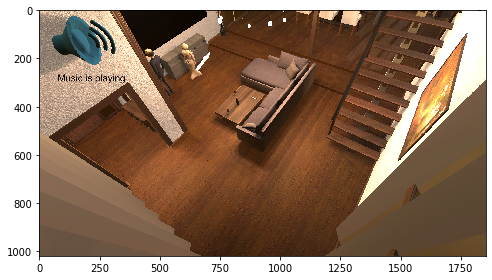

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.2967       |         1.2243        |         0.1826        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                           2.50        3.376592
Mopping the floor                         3.20        3.754878
Carry warm food                           3.40        3.443155
Carry cold food                           3.35        3.342947
Carry drinks                              3.35        3.522949
Carry small objects (plates, toys)        3.60        3.750479
Carry big objects (tables, chairs)        3.00        3.046179
Starting conversation                     2.30        2.804227

Scene number: 547


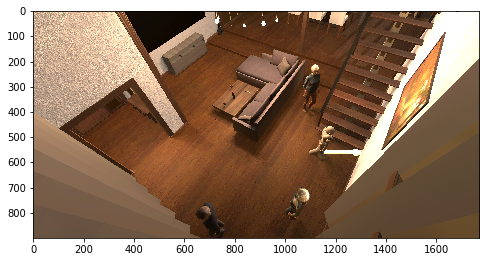

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.9226       |         1.2562        |         0.1346        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       3.200000        2.757650
Mopping the floor                     3.266667        2.943593
Carry warm food                       2.800000        3.165641
Carry cold food                       2.666667        3.298291
Carry drinks                          2.866667        3.615500
Carry small objects (plates, toys)    3.333333        3.623580
Carry big objects (tables, chairs)    2.600000        2.760894
Starting conversation                 2.400000        3.274329

Scene number: 486


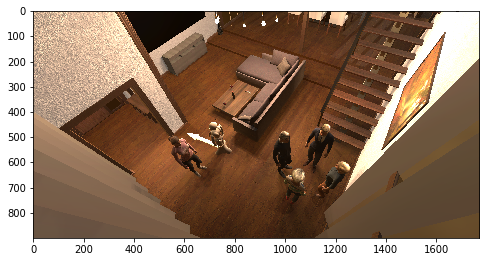

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.8764       |         1.4468        |         0.1123        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.428571        2.500242
Mopping the floor                     2.714286        2.352066
Carry warm food                       3.285714        3.018411
Carry cold food                       3.571429        2.913138
Carry drinks                          3.571429        2.860672
Carry small objects (plates, toys)    3.714286        3.283622
Carry big objects (tables, chairs)    2.428571        2.206946
Starting conversation                 2.285714        2.680191

Scene number: 674


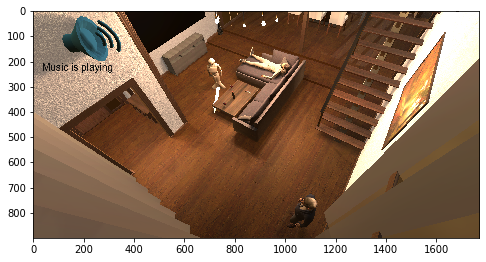

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.0594       |         1.3382        |         0.1676        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                         2.5000        2.881751
Mopping the floor                       3.3125        3.545211
Carry warm food                         3.3125        3.469379
Carry cold food                         3.3750        3.453092
Carry drinks                            3.3750        3.375856
Carry small objects (plates, toys)      3.5000        3.995871
Carry big objects (tables, chairs)      2.8750        2.959973
Starting conversation                   2.2500        3.305165

In [11]:
# Print evaluation along with image
counter = 0
for action_type in test_scenes:
    for scene_index, scene in enumerate(action_type):
        counter += 1
        if counter < 20:
            continue
        print('Scene number:', scene)
        # Print image
        if features.loc[features['Stamp'] == scene].empty:
            image_path = '/Users/jonastjomsland/Dissertation/' + features.loc[features['Stamp'] == str(scene)]['File Path'].values[0]
        else:
            image_path = '/Users/jonastjomsland/Dissertation/' + features.loc[features['Stamp'] == scene]['File Path'].values[0]
        img = plt.imread(image_path)
        plt.figure(figsize = (8,10))
        plt.rcParams["axes.grid"] = False
        imgplot = plt.imshow(img)
        plt.show()
        # Create dataframe to view results:
        #eval_df = pd.DataFrame(columns= ['Mean label', 'Variance in labels', 'Predicted mean', 'Aleatoric uncertainty', 'Epistemic uncertainty'])
        eval_df = pd.DataFrame(columns= ['Mean label', 'Predicted mean'])        
        for column in eval_df:
            eval_df[column] = evaluation_dict[scene][column]
        eval_df.index = evaluation_dict[scene]['Actions']
        eval_df.index.name = 'Actions'
        # Print average Epistemic and Aleatoric uncertainty
        table = PrettyTable()
        table.field_names = ['Variance in labels', 'Aleatoric uncertainty', 'Epistemic uncertainty']
        table.add_row([np.round(np.mean(evaluation_dict[scene]['Variance in labels']), 4), np.round(np.mean(evaluation_dict[scene]['Aleatoric uncertainty']),4), np.round(np.mean(evaluation_dict[scene]['Epistemic uncertainty']), 4)])
        print(table)
        # Display predictions
        display(eval_df)
        if counter > 30:
            counter = 0
            break